<h1>Phần 1:Thu thập dữ liệu</h1>

<h2>1.1 Crawl </h2>

**Bao gồm các bước sau:**
- Sử dụng thư viện requests để gửi yêu cầu GET đến trang web IMDB.
- Sử dụng thư viện BeautifulSoup để phân tích nội dung HTML trả về từ yêu cầu.
- Xác định các phần tử trên trang web chứa thông tin cần thu thập (ví dụ: tiêu đề phim, năm phát hành, đánh giá IMDb, số phiếu bầu, thể loại, thời lượng, v.v.).
- Trích xuất thông tin từ các phần tử và lưu trữ vào các biến hoặc mảng.
- Lặp lại quá trình trên các trang khác nhau để thu thập thông tin từ nhiều trang.

In [1]:
from requests import get
from bs4 import BeautifulSoup
from warnings import warn
from time import sleep
import numpy as np
import pandas as pd


# Tạo mảng với các giá trị cách nhau 50 vì trang tổng hợp mỗi trang có 50 phim
pages = np.arange(1, 51, 50)
# Định nghĩa header để phù hợp mới trang imdb
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.8'
}

# Tạo mảng trống
titles_col = []
years_col = []
ratings_col = []
genres_col = []
runtimes_col = []
imdb_ratings_col = []
votes_col = []
releaseds_col = []
budgets_col = []
companies_col = []
origins_col = []
grosses_col = []
directors_col = []
writers_col = []
stars_col = []
count = 0

for page in pages:
    # Gửi yêu cầu GET để lấy nội dung trên trang tổng hợp IMDb.
    response = get("https://www.imdb.com/search/title/?title_type=feature&num_votes=10000,"
                   + "&start="
                   + str(page)
                   + "&ref_=adv_nxt", headers=headers)

    sleep(10)

    # check lỗi trạng thái
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))

    # sử dụng thư viện BeautifulSoup để phân tích nội dung HTML được trả về từ yêu cầu response.
    page_html = BeautifulSoup(response.text, 'html.parser')

    movie_containers = page_html.find_all('div', class_='lister-item mode-advanced')

    print(len(movie_containers))
    
    # Extract the 50 movies for that page
    for container in movie_containers:
        if container.find('div', class_='lister-item-image float-left') is not None:
            print(container.find('div', class_='lister-item-image float-left').find('a')['href'])
            href = container.find('div', class_='lister-item-image float-left').find('a')['href']
            print("https://www.imdb.com"
                  + href
                  + "?ref_=adv_li_tt")
            response_sub = get("https://www.imdb.com"
                               + href
                               + "?ref_=adv_li_tt", headers=headers)

            sleep(10)

            # Throw warning for status codes that are not 200
            if response_sub.status_code != 200:
                warn('Request: {}; Status code: {}'.format(requests, response_sub.status_code))

            # trích xuất 50 phim trong trang tổng hợp
            page_html_sub = BeautifulSoup(response_sub.text, 'html.parser')
            # khởi tạo các biến lưu giá trị của trừng phim
            released = None
            budget = None
            gross = None
            wins = '0'
            nominations = '0'
            companies_arr = []
            origins_arr = []
            directors_arr = []
            writers_arr = []
            stars_arr = []

            # lấy các feature của từng phime
            # released
            if page_html_sub.find('li', {'data-testid': 'title-details-releasedate'}) is not None:
                released = page_html_sub.find('li', {'data-testid': 'title-details-releasedate'}).div.text.split('(')[0].rstrip()
            # budget
            if page_html_sub.find('li', {'data-testid': 'title-boxoffice-budget'}) is not None:
                if "$" in page_html_sub.find('li', {'data-testid': 'title-boxoffice-budget'}).div.text:
                    budget = float(
                        page_html_sub.find('li', {'data-testid': 'title-boxoffice-budget'}).div.text.split('(')[0].rstrip().split("$")[1].replace(",", ""))
            # gross
            if page_html_sub.find('li', {'data-testid': 'title-boxoffice-cumulativeworldwidegross'}) is not None:
                if "$" in page_html_sub.find('li', {'data-testid': 'title-boxoffice-cumulativeworldwidegross'}).div.text:
                    gross = float(
                        page_html_sub.find('li', {'data-testid': 'title-boxoffice-cumulativeworldwidegross'}).div.text.split('(')[0].rstrip().split("$")[1].replace(",", ""))
            # origin
            if page_html_sub.find('li', {'data-testid': 'title-details-origin'}) is not None:
                origins = page_html_sub.find('li', {'data-testid': 'title-details-origin'}).find_all('li')
                for origin in origins:
                    origins_arr.append(origin.text.rstrip())
            # companies
            if page_html_sub.find('li', {'data-testid': 'title-details-companies'}) is not None:
                companies = page_html_sub.find('li', {'data-testid': 'title-details-companies'}).find_all('li')
                for company in companies:
                    companies_arr.append(company.text.rstrip())
            # writers, starts, director
            if page_html_sub.find_all('li', {'data-testid': 'title-pc-principal-credit'}) is not None:
                options = page_html_sub.find_all('li', {'data-testid': 'title-pc-principal-credit'})
                half_length = len(options) // 2
                options = options[:half_length]

                for option in options:
                    if option.find('span', class_="ipc-metadata-list-item__label ipc-metadata-list-item__label--btn") and 'Director' in option.find('span', class_="ipc-metadata-list-item__label ipc-metadata-list-item__label--btn").text:
                        directors = option.find_all('li')
                        for director in directors:
                            directors_arr.append(director.text.rstrip())

                    if option.find('span', class_="ipc-metadata-list-item__label ipc-metadata-list-item__label--btn") and 'Writer' in option.find('span', class_="ipc-metadata-list-item__label ipc-metadata-list-item__label--btn").text:
                        writers = option.find_all('li')
                        for writer in writers:
                            writers_arr.append(writer.text.rstrip())

                    if option.find('a', class_="ipc-metadata-list-item__label ipc-metadata-list-item__label--link") and 'Director' in option.find('a', class_="ipc-metadata-list-item__label ipc-metadata-list-item__label--link").text:
                        directors = option.find_all('li')
                        for director in directors:
                            directors_arr.append(director.text.rstrip())

                    if option.find('a', class_="ipc-metadata-list-item__label ipc-metadata-list-item__label--link") and 'Writer' in option.find('a', class_="ipc-metadata-list-item__label ipc-metadata-list-item__label--link").text:
                        writers = option.find_all('li')
                        for writer in writers:
                            writers_arr.append(writer.text.rstrip())

                    if option.find('a', class_="ipc-metadata-list-item__label ipc-metadata-list-item__label--link") and 'Stars' in option.find('a', class_="ipc-metadata-list-item__label ipc-metadata-list-item__label--link").text:
                        stars = option.find_all('li')
                        for star in stars:
                            stars_arr.append(star.text.rstrip())

                    if option.find('span', class_="ipc-metadata-list-item__label ipc-metadata-list-item__label--btn") and 'Star' in option.find('span', class_="ipc-metadata-list-item__label ipc-metadata-list-item__label--btn").text:
                        stars = option.find_all('li')
                        for star in stars:
                            stars_arr.append(star.text.rstrip())
            #thêm dữ liệu vào các mảng ban đầu
            companies_col.append(companies_arr)
            directors_col.append(directors_arr)
            writers_col.append(writers_arr)
            stars_col.append(stars_arr)
            origins_col.append(origins_arr)
            releaseds_col.append(released)
            budgets_col.append(budget)
            grosses_col.append(gross)
        # Lấy các feature
        # Title
        title = container.h3.a.text
        titles_col.append(title)

        if container.h3.find('span', class_='lister-item-year text-muted unbold') is not None:
            # Year released
            year = container.h3.find('span', class_='lister-item-year text-muted unbold').text
            years_col.append(year)
        else:
            years_col.append(None)

        if container.p.find('span', class_='certificate') is not None:
            # Rating
            rating = container.p.find('span', class_='certificate').text
            ratings_col.append(rating)
        else:
            ratings_col.append("")

        if container.p.find('span', class_='genre') is not None:
            # Genre
            genre = container.p.find('span', class_='genre').text.replace("\n", "").rstrip().split(',')
            genres_col.append(genre)
        else:
            genres_col.append("")

        if container.p.find('span', class_='runtime') is not None:
            # Runtime
            time = int(container.p.find('span', class_='runtime').text.replace(" min", ""))
            runtimes_col.append(time)
        else:
            runtimes_col.append(None)

        if float(container.strong.text) is not None:
            # IMDb ratings
            imdb = float(container.strong.text)
            imdb_ratings_col.append(imdb)
        else:
            imdb_ratings_col.append(None)

        if container.find('span', attrs={'name': 'nv'})['data-value'] is not None:
            # Number of votes
            vote = int(container.find('span', attrs={'name': 'nv'})['data-value'])
            votes_col.append(vote)
        else:
            votes_col.append(None)

        count += 1
        print(count)
        if count == 10:
            break

# tạo dataframe 

sci_fi_df = pd.DataFrame({
    'title': titles_col,
    'year': years_col,
    'rating': ratings_col,
    'genre': genres_col,
    'runtime': runtimes_col,
    'imdb': imdb_ratings_col,
    'votes': votes_col,
    'releaseds': releaseds_col,
    'budgets': budgets_col,
    'companies': companies_col,
    'origins': origins_col,
    'gross': grosses_col,
    'directors': directors_col,
    'writers': writers_col,
    'stars': stars_col
})

sci_fi_df.loc[:, 'year'] = sci_fi_df['year'].str[-5:-1]
final_df = sci_fi_df.loc[sci_fi_df['year'] != 'ovie']
final_df.loc[:, 'year'] = pd.to_numeric(final_df['year'])

# Lưu data vao file csv

final_df.to_csv('data_test.csv', index=False)


50
/title/tt6791350/?ref_=adv_li_i
https://www.imdb.com/title/tt6791350/?ref_=adv_li_i?ref_=adv_li_tt
1
/title/tt13345606/?ref_=adv_li_i
https://www.imdb.com/title/tt13345606/?ref_=adv_li_i?ref_=adv_li_tt
2
/title/tt2906216/?ref_=adv_li_i
https://www.imdb.com/title/tt2906216/?ref_=adv_li_i?ref_=adv_li_tt
3
/title/tt4873118/?ref_=adv_li_i
https://www.imdb.com/title/tt4873118/?ref_=adv_li_i?ref_=adv_li_tt
4
/title/tt7405458/?ref_=adv_li_i
https://www.imdb.com/title/tt7405458/?ref_=adv_li_i?ref_=adv_li_tt
5
/title/tt6718170/?ref_=adv_li_i
https://www.imdb.com/title/tt6718170/?ref_=adv_li_i?ref_=adv_li_tt
6
/title/tt16419074/?ref_=adv_li_i
https://www.imdb.com/title/tt16419074/?ref_=adv_li_i?ref_=adv_li_tt
7
/title/tt6968614/?ref_=adv_li_i
https://www.imdb.com/title/tt6968614/?ref_=adv_li_i?ref_=adv_li_tt
8
/title/tt13375076/?ref_=adv_li_i
https://www.imdb.com/title/tt13375076/?ref_=adv_li_i?ref_=adv_li_tt
9
/title/tt11358390/?ref_=adv_li_i
https://www.imdb.com/title/tt11358390/?ref_=adv_l

C:\Users\nhath\AppData\Local\Temp\ipykernel_16632\2672978274.py:230: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  final_df.loc[:, 'year'] = pd.to_numeric(final_df['year'])


<h2>1.2 Trực quan dữ liệu </h2>

<h3>Thêm các thư viện cần thiết<h3>

In [2]:
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing
import ast
import seaborn as sns # data visualization
import matplotlib.pyplot as plt # data visualization
warnings.simplefilter('ignore')

<h3>Đọc dữ liệu đầu vào từ file .csv</h3>

In [3]:
data = pd.read_csv('../../raw_data/Small_DS_raw.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1000 non-null   object 
 1   year       1000 non-null   int64  
 2   rating     996 non-null    object 
 3   genre      1000 non-null   object 
 4   runtime    1000 non-null   int64  
 5   imdb       1000 non-null   float64
 6   votes      1000 non-null   int64  
 7   releaseds  1000 non-null   object 
 8   budgets    872 non-null    float64
 9   companies  1000 non-null   object 
 10  origins    1000 non-null   object 
 11  gross      941 non-null    float64
 12  directors  1000 non-null   object 
 13  writers    1000 non-null   object 
 14  stars      1000 non-null   object 
dtypes: float64(3), int64(3), object(9)
memory usage: 117.3+ KB
None


<h3>Phân tách cột released thành các cột month, day, year, week_day</h3>

In [4]:
data_reduced = data.copy()

# how many values are in the 'released' column, that doesn't have a full date?
data_reduced['releaseds'].apply(lambda x: len(x.split('(')[0].split()) != 3).sum()
# drop these rows
data_reduced.drop(data_reduced[data_reduced['releaseds'].apply(lambda x: len(x.split('(')[0].split()))!= 3].index, inplace=True)
data_reduced['releaseds'].apply(lambda x: len(x.split('(')[0].split()) != 3).sum()
data_reduced['releaseds'] = data_reduced['releaseds'].apply(lambda x: x.split('(')[0])
data_reduced['releaseds'] = pd.to_datetime(data_reduced['releaseds'])

# get month, day, and day of the week from released
data_reduced['month'] = data_reduced['releaseds'].dt.month
data_reduced['day'] = data_reduced['releaseds'].dt.day
data_reduced['week_day'] = data_reduced['releaseds'].dt.dayofweek

In [5]:
# reorder columns
data_reduced = data_reduced[['title', 'rating', 'genre', 'releaseds', 'year', 'month', 'day',
                          'week_day', 'imdb', 'votes', 'directors', 'writers', 'stars',
                          'origins', 'budgets', 'companies', 'runtime']].copy()


In [6]:
# split columns into numerical and categorical (exclude the PassengerId)
float_cols = data_reduced.drop('title', axis=1).dtypes[data_reduced.dtypes == 'float64'].index.tolist()
int_cols = data_reduced.drop('title', axis=1).dtypes[data_reduced.dtypes == 'int64'].index.tolist()
cat_cols = data_reduced.drop('title', axis=1).dtypes[data_reduced.dtypes == 'object'].index.tolist()
num_cols = float_cols + int_cols
binary = [x for x in num_cols if len(data_reduced[x].unique()) == 2]
num_not_binary = [x for x in num_cols if x not in binary]


<h3>Trực quan thống kê các dữ liệu số </h3>

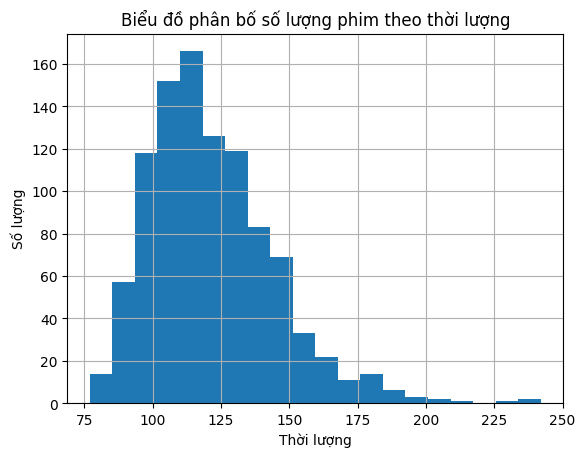

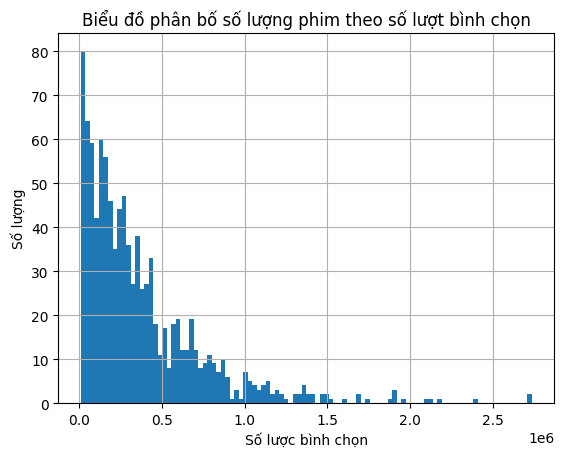

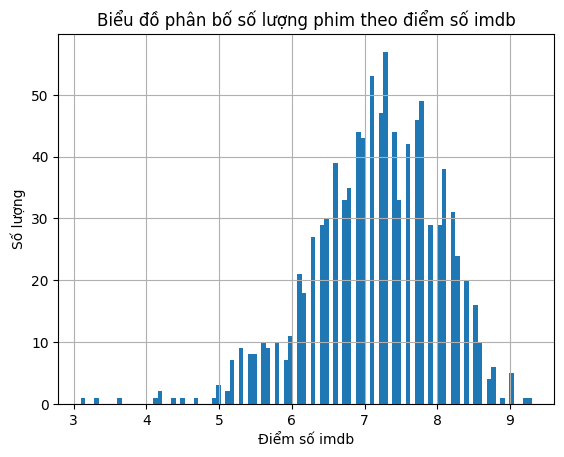

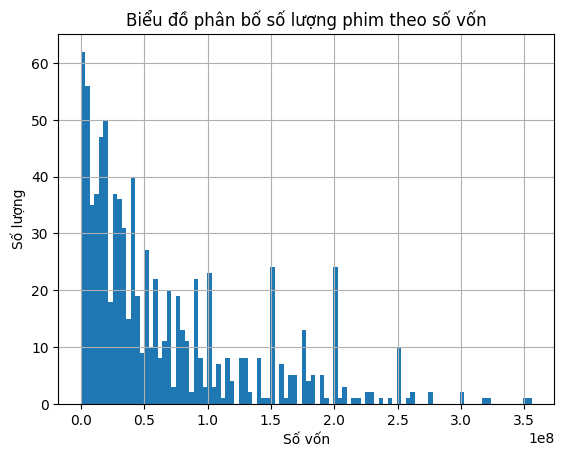

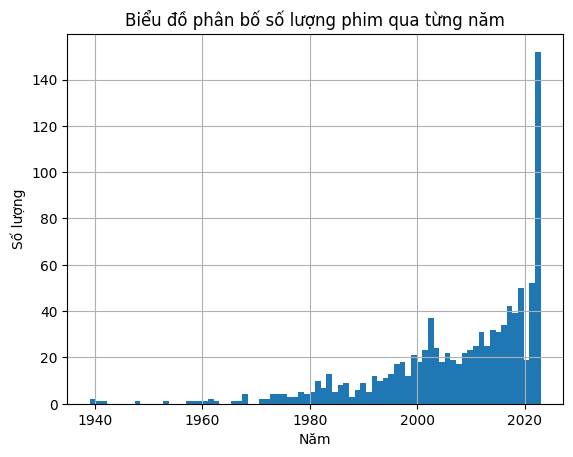

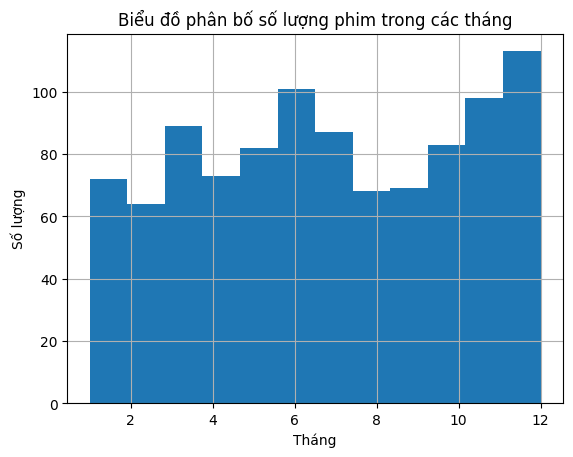

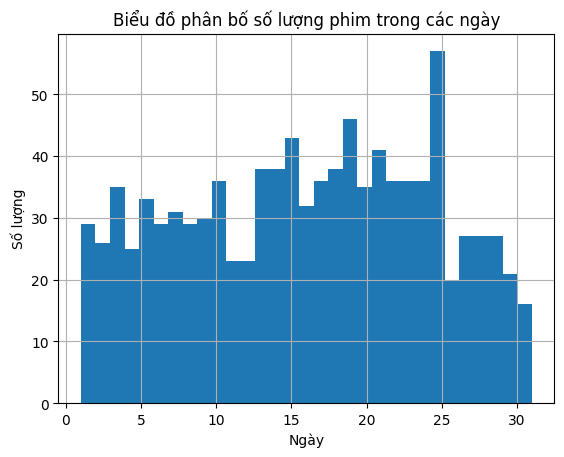

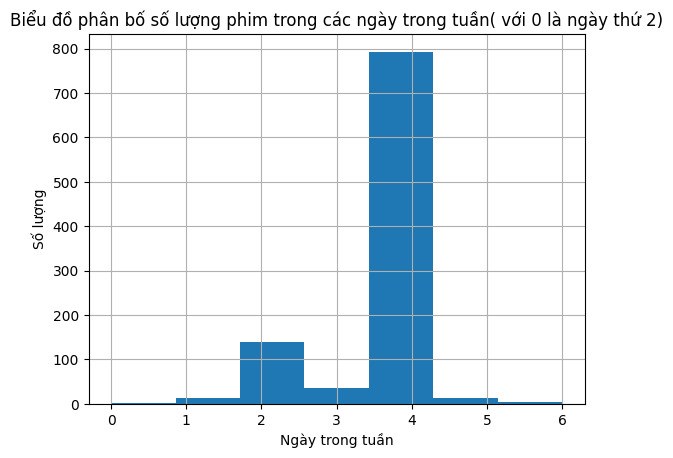

In [7]:
# runtime
data_reduced.hist(column='runtime', bins=20)

plt.title('Biểu đồ phân bố số lượng phim theo thời lượng')
plt.xlabel('Thời lượng')
plt.ylabel('Số lượng')

plt.show()
# votes
data_reduced.hist(column='votes', bins=100)

plt.title('Biểu đồ phân bố số lượng phim theo số lượt bình chọn')
plt.xlabel('Số lược bình chọn')
plt.ylabel('Số lượng')

plt.show()
#imdb
data_reduced.hist(column='imdb', bins=100)

plt.title('Biểu đồ phân bố số lượng phim theo điểm số imdb')
plt.xlabel('Điểm số imdb')
plt.ylabel('Số lượng')

plt.show()
#budget
data_reduced.hist(column='budgets', bins=100)

plt.title('Biểu đồ phân bố số lượng phim theo số vốn')
plt.xlabel('Số vốn')
plt.ylabel('Số lượng')

plt.show()
#year
data_reduced.hist(column='year', bins=80)

plt.title('Biểu đồ phân bố số lượng phim qua từng năm')
plt.xlabel('Năm')
plt.ylabel('Số lượng')

plt.show()
#month
data_reduced.hist(column='month', bins=12)

plt.title('Biểu đồ phân bố số lượng phim trong các tháng')
plt.xlabel('Tháng')
plt.ylabel('Số lượng')

plt.show()
#day
data_reduced.hist(column='day', bins=31)

plt.title('Biểu đồ phân bố số lượng phim trong các ngày')
plt.xlabel('Ngày')
plt.ylabel('Số lượng')

plt.show()
#week_day
data_reduced.hist(column='week_day', bins=7)

plt.title('Biểu đồ phân bố số lượng phim trong các ngày trong tuần( với 0 là ngày thứ 2)')
plt.xlabel('Ngày trong tuần')
plt.ylabel('Số lượng')

plt.show()


**Nhận xết**
- Số lượng phim sản xuất qua các năm gần như tăng dần, cho thấy nhu cầu xem phim, giải trí càng tăng. Ta cũng nhận thấy các năm 2020 số lượng có giảm rõ rêt, điều này là do tác động rất lớn từ đại dịch covid-19.
- Điểm số imdb tập trung nhiêu ở mức 6.5 - 8.0.
- Kinh phí đầu tư cho một bộ phim đa số bé hơn 50.000.000 dollar.
- Số lượt bình chọn cho một bộ phim đa số bé hơn 300.000 lượt.
- Phim chủ yếu ra mắt vào ngày thứ 6 trong tuần, điều này liên quan đến thói quen đi xem phim của người xem.


<h3>Trực quan mối quan hệ của các dữ liệu số với nhau</h3>

<Axes: >

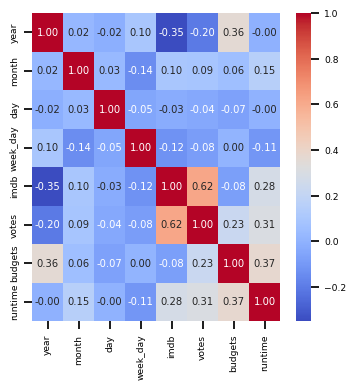

In [8]:
# look at correlations between variables
from matplotlib import pyplot


sns.set_context('notebook', font_scale=0.6)
fig, ax = pyplot.subplots(figsize=(4,4))
sns.heatmap(ax=ax, data=data_reduced.corr(), annot=True, fmt= '.2f', cmap='coolwarm')

**Nhận xét:**
- Mức độ tương quan giữa điểm imdb và runtime là 0.28.
- Mức độ tương quan giữa điểm imdb và vote là 0.62.
- Mức độ tương quan giữa điểm vote và budget là 0.23.
- Mức độ tương quan giữa điểm year và budget là 0.36.
- Mức độ tương quan giữa điểm runtime và budget là 0.37.


*Đây là nhưng cặp có mức độ tương quan cao so với các cặp còn lại. Thực hiện trực quan với các cặp giá trị trên*

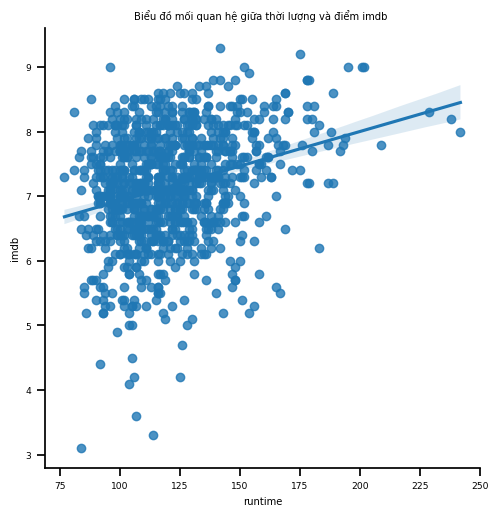

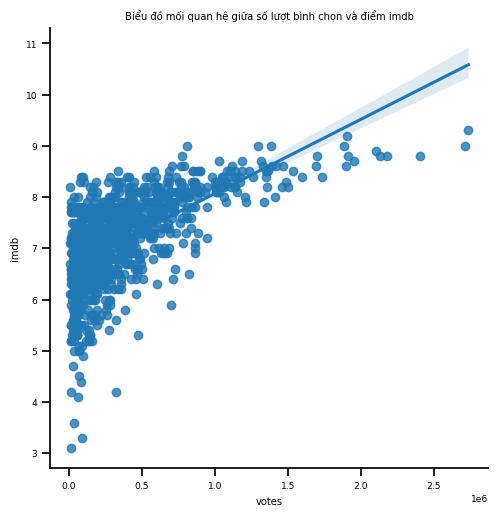

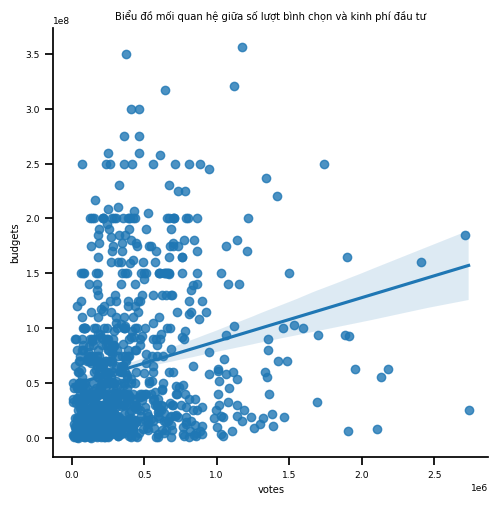

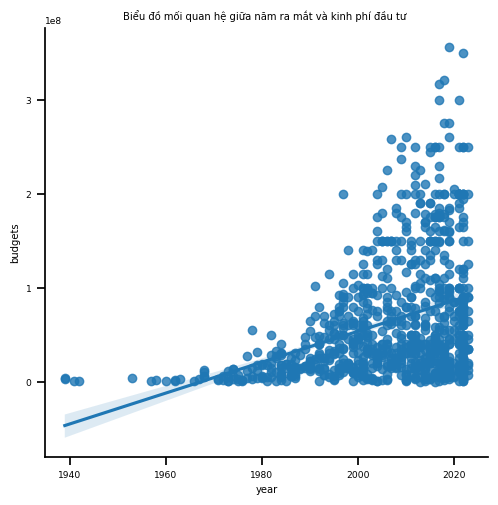

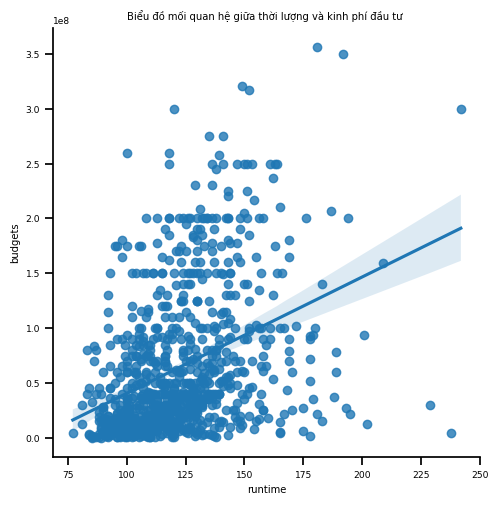

In [9]:
sns.lmplot(data=data_reduced, x='runtime', y='imdb')
plt.title(f"Biểu đồ mối quan hệ giữa thời lượng và điểm imdb ")
plt.show()
sns.lmplot(data=data_reduced, x='votes', y='imdb')
plt.title(f"Biểu đồ mối quan hệ giữa số lượt bình chọn và điểm imdb")
plt.show()
sns.lmplot(data=data_reduced, x='votes', y='budgets')
plt.title(f"Biểu đồ mối quan hệ giữa số lượt bình chọn và kinh phí đầu tư")
plt.show()
sns.lmplot(data=data_reduced, x='year', y='budgets')
plt.title(f"Biểu đồ mối quan hệ giữa năm ra mắt và kinh phí đầu tư ")
plt.show()
sns.lmplot(data=data_reduced, x='runtime', y='budgets')
plt.title(f"Biểu đồ mối quan hệ giữa thời lượng và kinh phí đầu tư ")
plt.show()

**Ta thấy các cặp giá trị trên đều đồng biến**


<h3>Trực quan thống kê dữ liệu object </h3>

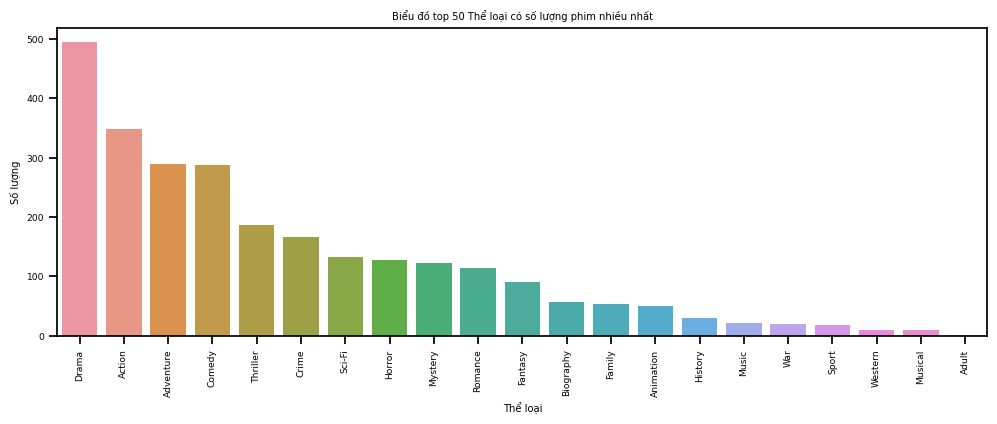

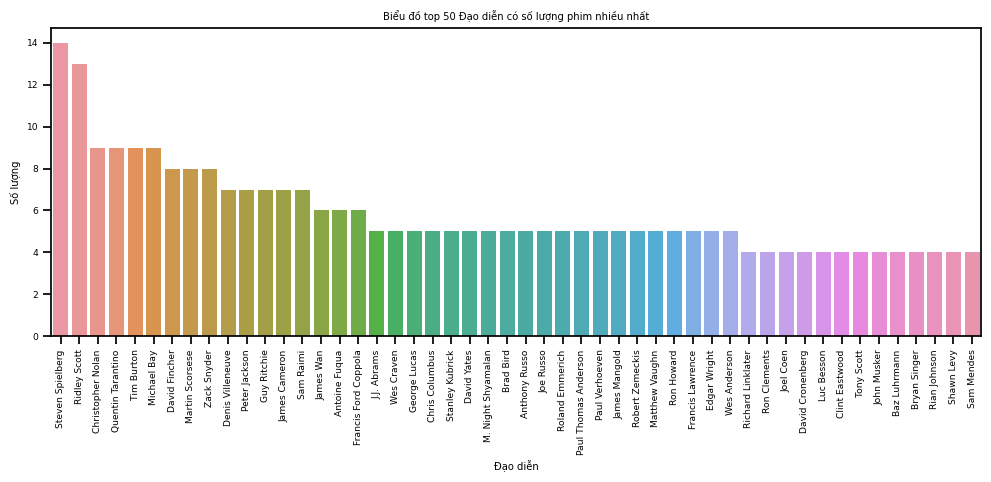

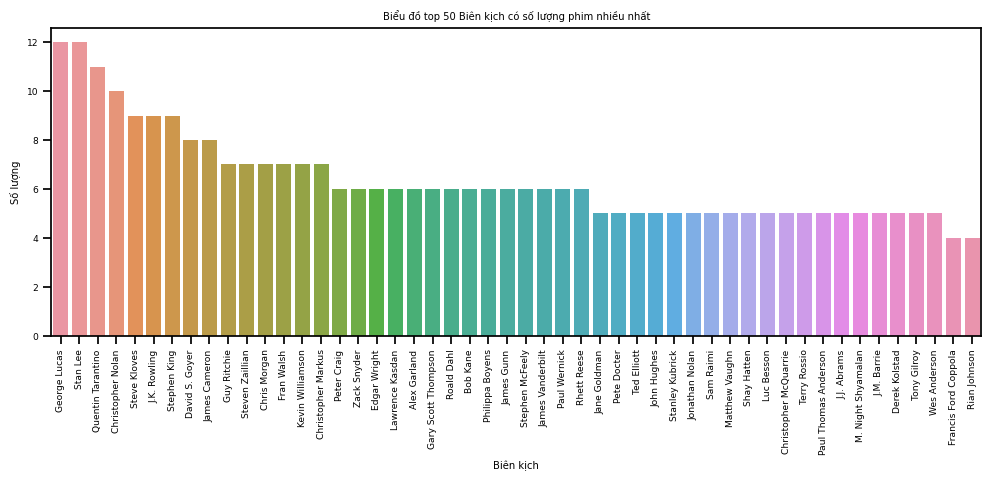

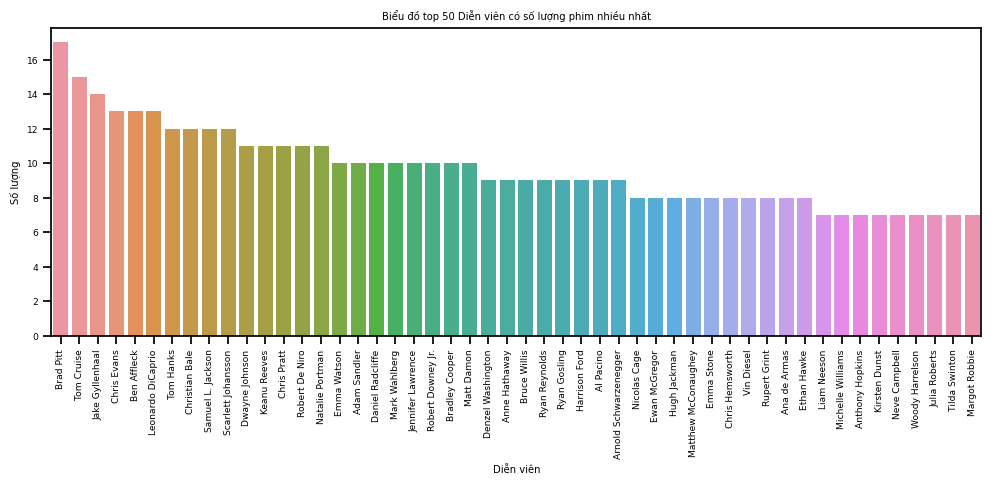

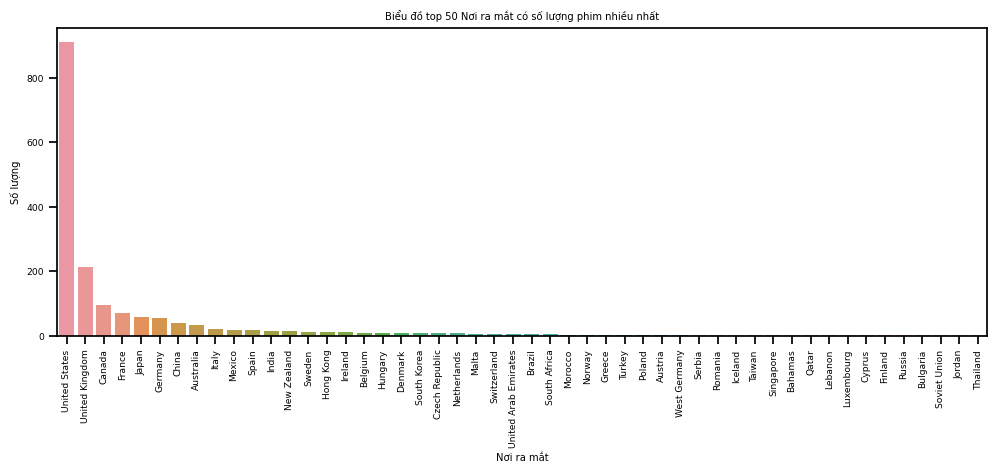

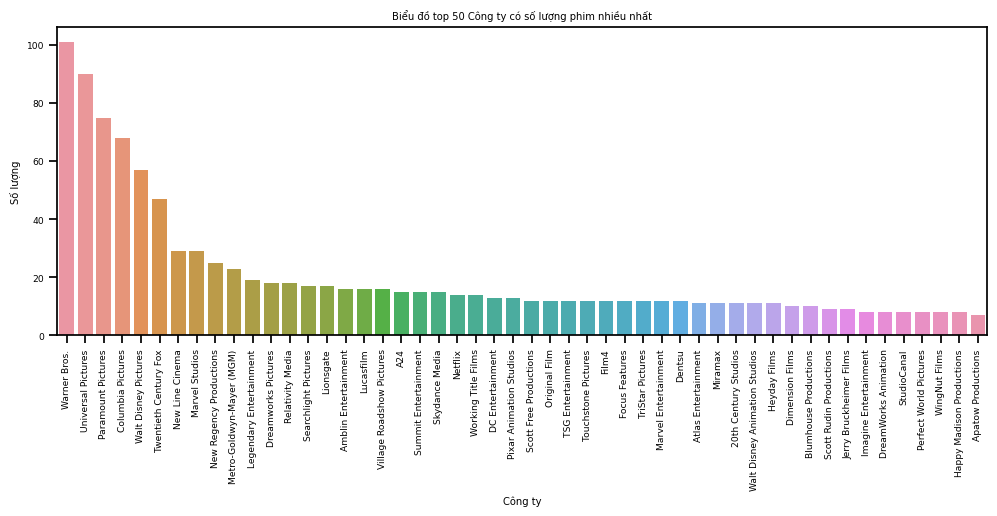

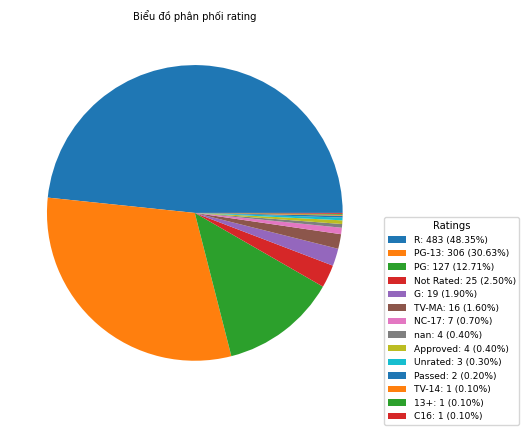

In [10]:
from matplotlib import ticker

title_feature = {'genre':'Thể loại', 'directors':'Đạo diễn','stars':'Diễn viên','writers':'Biên kịch','origins':'Nơi ra mắt','companies':'Công ty'}

for i in cat_cols + binary:

    if i!='rating':
        data_reduced[i] = data_reduced[i].apply(lambda x: [genre.strip() for genre in ast.literal_eval(x)])
        exp = data_reduced[i].explode().str.strip().value_counts()

        plt.figure(figsize=(12, 4))
        sns.barplot(x=exp.index[0:50], y=exp[0:50])
        plt.xticks(rotation='vertical')
        plt.title('Biểu đồ top 50 ' + title_feature[i]+' có số lượng phim nhiều nhất')
        plt.xlabel(title_feature[i])
        plt.ylabel('Số lượng')
        plt.show()



ratings = data_reduced['rating'].astype(str).str.split(',').explode().str.strip()


# Đếm số lần xuất hiện của mỗi genred
rating_counts = ratings.value_counts()
# Tạo biểu đồ Pie chart
plt.pie(rating_counts.values, labels=None)

# Tạo bảng chú thích
legend_labels = [f'{rating}: {count} ({count / len(ratings) * 100:.2f}%)' for rating, count in zip(rating_counts.index, rating_counts.values)]
plt.legend(legend_labels, title='Ratings', loc='best', bbox_to_anchor=(1, 0.5))

# Đặt tiêu đề cho biểu đồ
plt.title('Biểu đồ phân phối rating')

# Định dạng phần trăm trên trục y của bảng chú thích
formatter = ticker.PercentFormatter(xmax=len(ratings))
plt.gca().yaxis.set_major_formatter(formatter)

# Hiển thị biểu đồ và bảng chú thích
plt.show()

**Nhận xét:**
- Các phim đa số ra mắt ở United States, đây là thị trường màu mỡ đối với các nhà làm phim.
- Thể loại drama là loại phim có số lượng nhiều nhất.
- Các phim thuộc loại R, PG-13, PG, Not Rated là chiếm phần lớn.